In [100]:
import os
import sys
import glob

# Set the path to the directory with GeoTiff files
folder_path = 'SAR_amplitude'

if not os.path.isdir(folder_path):
    raise ValueError('folder_path should be set a directory.')


## Get a list of geotiff files
geotiff_files = glob.glob(os.path.join(folder_path, '*.tif'))
geotiff_files.sort()
if len(geotiff_files) == 0:
    raise ValueError('folder_path does not contain any GeoTiff files.')

# Install packages
!{sys.executable} -m pip install ipyleaflet ipympl

%matplotlib widget

Defaulting to user installation because normal site-packages is not writeable


In [103]:
import matplotlib.pyplot as plt
from datetime import datetime

def geographic_to_pixel(dataset, lon, lat):
    """
    Convert geographic coordinates to pixel coordinates.

    Parameters:
    dataset (rasterio.DatasetReader): The opened GeoTIFF file.
    lon (float): Longitude of the geographic location.
    lat (float): Latitude of the geographic location.

    Returns:
    (int, int): The (row, col) location of the pixel.
    """
    transform = dataset.transform
    col, row = ~transform * (lon, lat)
    return int(row), int(col)

class Timeseries:
    """Class which keeps track of user interaction with the map and the generated time series"""
    
    def __init__(self):
        self.data = gpd.GeoDataFrame([datetime(1970,1,1)] * len(geotiff_files), columns=['date'])
        self.coordinate_count = 0
        self.coordinates = []
        self.fig = plt.figure()
        for i, geotiff_file in enumerate(geotiff_files):
    
            # Add an entry in the dataframe
            basename = os.path.basename(geotiff_file)
            date = basename.split('.')[0]
            self.data.loc[i] = datetime.strptime(os.path.basename(date), "%Y%m%d")
            
        #timeseries.data['date'] = timeseries.data['date_str'].apply(
        #    lambda val: datetime.datetime.strptime(val, "%Y%m%d")
        #)

    
    def click_event_handler(self, coordinates):
        """
        Function called when the map is clicked.
        """
        # TODO bounds check
        self.coordinates.append(coordinates)
        coord_label = f'values_{len(self.coordinates)}'

        print(coordinates)
        
        for i, geotiff_file in enumerate(geotiff_files):
            tiff_dataset = rasterio.open(geotiff_file)
            row, col = geographic_to_pixel(tiff_dataset, coordinates[1], coordinates[0])
            pixel_value = tiff_dataset.read(1)[row, col]
            self.data.loc[i, coord_label] = pixel_value
            #print(pixel_value)
        
        self.update_figure()

    def update_figure(self):
        #plt.figure(self.fig.number)
        plt.clf()
        for i, coord in enumerate(self.coordinates):
            plt.plot(self.data['date'], self.data[f'values_{i+1}'], 'o')
        

    def interaction_event_handler(self):
        def handler(**kwargs):
            """Function called when the user interacts with the map"""
            if kwargs['type'] == 'click':
                self.click_event_handler(kwargs['coordinates'])
        return handler
    

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

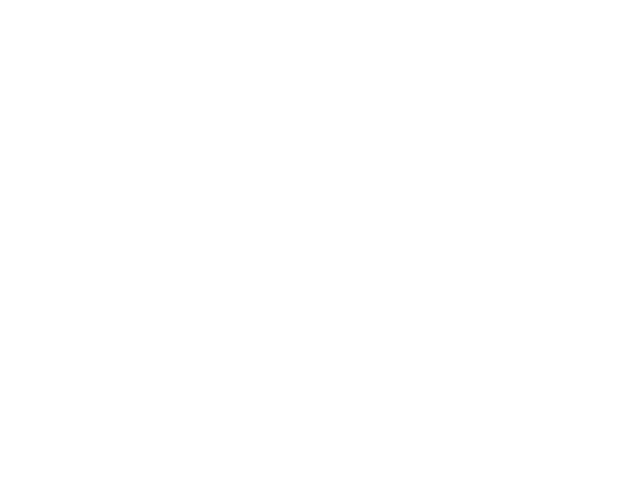

[26.86589349552882, 86.49110387407555]


In [104]:
from ipyleaflet import Map, basemaps, GeoData, Marker, Rectangle
from ipywidgets import HTML

import rasterio
import geopandas as gpd

## Create the map object
map = Map(zoom=2, basemap=basemaps.OpenStreetMap.HOT, scroll_wheel_zoom=True)

## Build a bounding box that contains the bounds of all the geotiff files.

# Start with the bounds of the first file
dataset = rasterio.open(geotiff_files[0])
bounds = dataset.bounds

for i, geotiff_file in enumerate(geotiff_files):
    dataset = rasterio.open(geotiff_file)

    # Join the bounds of the rest of the files
    bounds = rasterio.coords.BoundingBox(
        min(bounds.left, dataset.bounds.left),
        min(bounds.bottom, dataset.bounds.bottom),
        max(bounds.right, dataset.bounds.right),
        max(bounds.top, dataset.bounds.top),
    )

timeseries = Timeseries()

## Add the bounds to the map -- converting the rasterio.coords.BoundingBox object to ipyleaflet.Rectangle
map.add(Rectangle(bounds=((bounds.bottom, bounds.left), (bounds.top, bounds.right))))

## Add the event handler
map.on_interaction(timeseries.interaction_event_handler())
## Display the map
map